#### import relevant packages

In [38]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [39]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

In [40]:
# nltk.download("wordnet")
# nltk.download("punkt")
# nltk.download("averaged_perceptron_tagger")

#### loading in news dataset

In [41]:
import os 

base_dir = "../data/raw"

texts = []
topics = []

for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    if not os.path.isdir(folder_path):
        continue

    for file_name in os.listdir(folder_path):             # business, politics, entertainment etc..
        file_path = os.path.join(folder_path, file_name)
        
        if not file_name.endswith(".txt"):
            continue

        with open(file_path, 'r', encoding='utf-8', errors = 'ignore') as file:
            texts.append(file.read())  
            topics.append(folder_name)  

In [42]:
df = pd.DataFrame({'text': texts, 'topic': topics})

df.head()

,text,topic
0,Musicians to tackle US red tape\n\nMusicians' ...,entertainment
1,"U2's desire to be number one\n\nU2, who have w...",entertainment
2,Rocker Doherty in on-stage fight\n\nRock singe...,entertainment
3,Snicket tops US box office chart\n\nThe film a...,entertainment
4,Ocean's Twelve raids box office\n\nOcean's Twe...,entertainment


In [82]:
df['topic'].unique()

array(['entertainment', 'business', 'sport', 'politics', 'tech'],
      dtype=object)

In [43]:
X = df['text']
y = df['topic']

<Axes: >

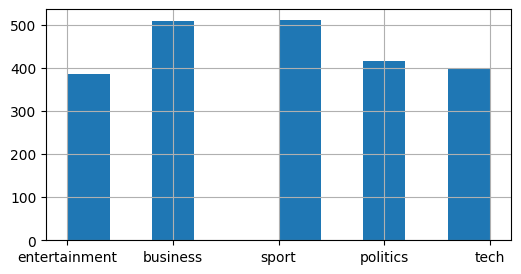

In [44]:
y.hist(figsize = (6,3))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [46]:
vectorizer = CountVectorizer()

X_train_text = X_train
X_test_text = X_test

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [47]:
"""
matrix of size (no. of data_samples) X (vocab_size).
N x V

it's sparse matrix representation because it is more efficient, 
especially when most of the values in the matrix are 0s.
"""

X_train   

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 335821 stored elements and shape (1668, 26079)>

In [48]:
"""
~ 0.8% (<1%) of the matrix contains non-zero values, 
hence this justify the use of sparse matrix representation.
"""

(X_train != 0).sum() / np.prod(X_train.shape)  

np.float64(0.007720063452286601)

In [74]:
X_test.shape

(557, 26079)

In [79]:
model = MultinomialNB()
model.fit(X_train, y_train)

print("train_score", model.score(X_train, y_train))
print("test_score", model.score(X_test, y_test), "\n")

print(f"out of {X_test.shape[0]} test articles, {(1-model.score(X_test, y_test)) * X_test.shape[0]:.0f} are misclassified")

train_score 0.9934052757793765
test_score 0.9748653500897666 

out of 557 test articles, 14 are misclassified


#### Evaluation

In [71]:
results = pd.concat([X_test_text, y_test], axis = 1).reset_index() #keeping the index for later scruity uses.

y_pred = model.predict(X_test)

y_pred_series = pd.Series(y_pred)
y_pred_series

results = pd.concat([results, y_pred_series], axis = 1)
results.columns = ['index of x_test', 'text', 'actual', 'predicted']
results

,index of x_test,text,actual,predicted
0,414,China now top trader with Japan\n\nChina overt...,business,business
1,420,Bush budget seeks deep cutbacks\n\nPresident B...,business,business
2,1644,MPs' murder sentence concern\n\nMurder sentenc...,politics,politics
3,416,GE sees 'excellent' world economy\n\nUS behemo...,business,business
4,1232,Rush future at Chester uncertain\n\nIan Rush's...,sport,sport
...,...,...,...,...
552,867,Aviation firms eye booming India\n\nIndia's de...,business,business
553,1220,El Guerrouj targets cross country\n\nDouble Ol...,sport,sport
554,1249,Ferguson fears Milan cutting edge\n\nMancheste...,sport,sport
555,1573,Correction agency plans dropped\n\nPlans to cr...,politics,politics


In [81]:
"""
examining those that misclassify
"""

results[results['actual'] != results['predicted']]

,index of x_test,text,actual,predicted
58,111,BBC 'should allow more scrutiny'\n\nMPs have u...,entertainment,tech
115,1379,Ferdinand casts doubt over Glazer\n\nRio Ferdi...,sport,business
116,679,Card fraudsters 'targeting web'\n\nNew safegua...,business,tech
141,290,Media seek Jackson 'juror' notes\n\nReporters ...,entertainment,politics
223,817,Call to overhaul UK state pension\n\nThe UK pe...,business,politics
264,1488,EU fraud clampdown urged\n\nEU member states a...,politics,business
349,1830,Games maker fights for survival\n\nOne of Brit...,tech,business
382,816,G7 backs Africa debt relief plan\n\nG7 finance...,business,politics
403,888,ID theft surge hits US consumers\n\nAlmost a q...,business,tech
411,808,UK young top Euro earnings league\n\nBritish c...,business,tech


In [83]:
wrong_case_index = 111  # Change this index
wrong_text = X_test_text[wrong_case_index]
wrong_vector = X_test[wrong_case_index]  # Sparse vector for that text

# # Get true and predicted labels
true_label = y_test[wrong_case_index]
predicted_label = y_pred[wrong_case_index]

# # Extract the words in the text
# wrong_words = np.array(feature_names)[wrong_vector.nonzero()[1]]

# # Get log probabilities of those words for both true and predicted classes
# true_class_probs = word_importance_df[true_label].loc[wrong_words]
# predicted_class_probs = word_importance_df[predicted_label].loc[wrong_words]

# # Compare word influence in a DataFrame
# word_contribution_df = pd.DataFrame({
#     "word": wrong_words,
#     f"log_prob_{true_label}": true_class_probs.values,
#     f"log_prob_{predicted_label}": predicted_class_probs.values
# })

# # Display results
# tools.display_dataframe_to_user(name="Word Contribution in Misclassified Case", dataframe=word_contribution_df)

#### After removal of english stopwords.